In [2]:
# This is a Bayesian Neural Network implementation using TensorFlow for a simple y = sin(x) function

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
# Check if GPU is available
print("GPU Available: ", tf.test.is_gpu_available())
print("GPU Name: ", tf.test.gpu_device_name())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
GPU Name:  /device:GPU:0


x shape: (1000,)
t shape: (1000,)
u0: (1000,)
U_1D shape: (1000,)
X shape: (1000, 1000)
T shape: (1000, 1000)
U shape: (1000, 1000)


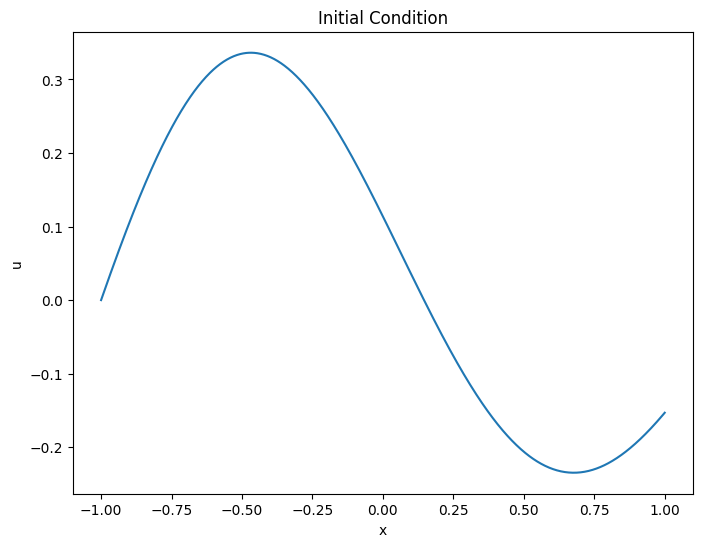

'# Plot the initial condition\nplt.figure(figsize=(8, 6))\nplt.pcolormesh(X, T, U, shading=\'auto\')\nplt.colorbar()\nplt.xlabel(\'x\')\nplt.ylabel(\'t\')\nplt.title("Burger\'s Equation Solution")\nplt.show()'

In [4]:
# Define the parameters for the Burger's equation
nu = 0.2 / np.pi  # Viscosity
N = 1000  # Number of data points

# Generate the spatial domain
x = np.linspace(-1, 1, N)
t = np.linspace(0, 1, N)
X, T = np.meshgrid(x, t)

# Initial condition
u0 = -np.sin(np.pi * x)

# Generate the dataset
def burgers_exact(x, t, nu):
    return -2 * nu * np.pi * np.sin(np.pi * (x - 4 * nu * t)) * np.exp(-np.pi**2 * nu * t)
# Exact solution: u(x, t) = -2 * nu * pi * sin(pi * (x - 4 * nu * t)) * exp(-pi^2 * nu * t)
# If t = 0, u(x, 0) = -2 * nu * pi * sin(pi * x) = -2 * 0.01/pi * pi * sin(pi * x) = -0.02 * sin(pi * x)
# If t = 1, u(x, 1) = -2 * nu * pi * sin(pi * (x - 4 * nu)) = -2 * 0.01/pi * pi * sin(pi * (x - 4 * 0.01/pi)) = -0.02 * sin(pi * (x - 4 * 0.01/pi))

U_1D = burgers_exact(x, t, nu)
U = burgers_exact(X, T, nu)

# Plot sizes of all the data
print("x shape:", x.shape)
print("t shape:", t.shape)
print("u0:", u0.shape)
print("U_1D shape:", U_1D.shape)
print("X shape:", X.shape)
print("T shape:", T.shape)
print("U shape:", U.shape)

plt.figure(figsize=(8, 6))
plt.plot(x, U_1D)
plt.xlabel('x')
plt.ylabel('u')
plt.title('Initial Condition')
plt.show()

'''# Plot the initial condition
plt.figure(figsize=(8, 6))
plt.pcolormesh(X, T, U, shading='auto')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title("Burger's Equation Solution")
plt.show()'''

In [5]:
# Define the loss function (negative log posterior)
def negative_log_posterior(model, U, U_pred):
    # We minimize the negative log posterior
    return -model.log_posterior(U, U_pred)

def pde_residual(model, x, t, u, nu):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x)
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            #u = model.forward(tf.concat([x], axis=1))
            u = model.forward(x)
        u_x = tape.gradient(u, x)
    u_xx = tape2.gradient(u_x, x)
    #u_t = tape.gradient(u, t)
    residual = u * u_x - nu * u_xx
    return residual

def pinn_loss(model, x, t, u0, nu):
    # Initial condition loss
    #u_pred_initial = model.forward(tf.concat([x, tf.zeros_like(x)], axis=1))
    #loss_initial = tf.reduce_mean(tf.square(u_pred_initial - u0))

    # Boundary condition loss
    #u_pred_left = model.forward(tf.concat([tf.ones_like(t) * x[0], t], axis=1))
    #u_pred_right = model.forward(tf.concat([tf.ones_like(t) * x[-1], t], axis=1))
    #loss_boundary = tf.reduce_mean(tf.square(u_pred_left)) + tf.reduce_mean(tf.square(u_pred_right))
    u_pred_left = model.forward([x[0]])
    u_pred_right = model.forward([x[-1]])
    loss_boundary = tf.reduce_mean(tf.square(u_pred_left)) + tf.reduce_mean(tf.square(u_pred_right))

    '''# PDE residual loss
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        u_pred = model(tf.concat([x, t], axis=1))
    residual = pde_residual(u_pred, x, t, nu)
    loss_pde = tf.reduce_mean(tf.square(residual))'''

    # Total loss
    total_loss = loss_boundary 
    return total_loss

In [6]:
Y = burgers_exact(x, t, nu)
X = x
Y = Y.reshape(-1, 1).astype(np.float32)
X = X.reshape(-1, 1).astype(np.float32)
hidden1 = N

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the neural network architecture
class BayesianNeuralNetwork:
    def __init__(self, input_dim, hidden1, hidden2, output_dim, prior_std):
        # Initialize weights and biases as TensorFlow variables
        initializer = tf.initializers.GlorotUniform()

        # Define trainable parameters (weights and biases)
        self.weights = [
            tf.Variable(initializer([input_dim, hidden1]), dtype=tf.float32),
            tf.Variable(initializer([hidden1, hidden2]), dtype=tf.float32),
            tf.Variable(initializer([hidden2, output_dim]), dtype=tf.float32)
        ]
        
        self.biases = [
            tf.Variable(tf.zeros([hidden1]), dtype=tf.float32),
            tf.Variable(tf.zeros([hidden2]), dtype=tf.float32),
            tf.Variable(tf.zeros([output_dim]), dtype=tf.float32)
        ]

        # Prior parameters (assuming Gaussian priors)
        self.prior_std = prior_std
        self.prior_vars = [
            tf.constant(self.prior_std**2, dtype=tf.float32) for _ in self.weights + self.biases
        ] # sigma**2. We assume that the prior is N(0, sigma**2).
        # for _ in self.weights + self.biases: create a list of prior_vars with the same length as weights and biases
        # So it creates a list of prior_vars for each weight and bias, total 6 elements in the list
        # The prior_std is the standard deviation of the prior, and we assume that the prior is N(0, sigma**2)

    def forward(self, X):
        # Layer 1 with tanh activation
        hidden1 = tf.matmul(X, self.weights[0]) + self.biases[0]
        hidden1_activation = tf.nn.tanh(hidden1)
        
        # Layer 2 with tanh activation
        hidden2 = tf.matmul(hidden1_activation, self.weights[1]) + self.biases[1]
        hidden2_activation = tf.nn.tanh(hidden2)
        
        # Output layer (linear activation)
        output = tf.matmul(hidden2_activation, self.weights[2]) + self.biases[2]
        return output

    def log_prior(self): # Role: Define initial beliefs about each parameter, acting as regularizers.
        # Compute log prior probability of weights and biases
        log_prior = 0.0
        for var, var_prior_var in zip(self.weights + self.biases, self.prior_vars): 
            # Assuming Gaussian prior: log p(w) = -0.5 * log(2πσ²) - w²/(2σ²)
            #log_prior += -0.5 * tf.reduce_sum(tf.math.log(2.0 * np.pi * var_prior_var**2)) # log(2πσ²)
            log_prior += -tf.reduce_sum(tf.square(var)) / (2.0 * var_prior_var**2) # -w²/(2σ²)
        log_prior_store.append(log_prior)
        return log_prior

    def log_likelihood(self, Y_true, Y_pred): # Role: Represents the probability of observing the data given the parameters, modeling how well the network fits the data.
        # Assuming Gaussian likelihood: p(Y|X,w) = N(Y_pred, σ²)
        # log p(Y|X,w) = -0.5 * log(2πσ²) - (Y - Y_pred)^2 / (2σ²)
        #log_likelihood = -0.5 * tf.cast(tf.size(Y_true), tf.float32) * tf.math.log(2.0 * np.pi * likelihood_std**2) # log(2πσ²)
        likelihood_std = np.std(Y_pred)
        log_likelihood = 0.0
        log_likelihood += -tf.reduce_sum(tf.square(Y_true - Y_pred)) / (2.0 * likelihood_std**2) # -(Y - Y_pred)^2 / (2σ²)
        log_likelihood_store.append(log_likelihood)
        return log_likelihood

    def log_posterior(self, Y_true, Y_pred): # Role: Combines priors and likelihood to update beliefs about parameters after observing the data.
        # log posterior ∝ log likelihood + log prior
        #print("Likelihood:   ", self.log_likelihood(Y_true, Y_pred))
        #print("Prior:   ", self.log_prior())
        log_posterior_store.append(self.log_likelihood(Y_true, Y_pred) + self.log_prior())
        return self.log_likelihood(Y_true, Y_pred) + self.log_prior()

# Initialize the Bayesian neural network
input_dim = 1
hidden1 = 30
hidden2 = 30
output_dim = 1
prior_std = np.sqrt(50/hidden1)  # Standard deviation for the prior
log_prior_store = []
log_likelihood_store = []
log_posterior_store = []

model = BayesianNeuralNetwork(input_dim, hidden1, hidden2, output_dim, prior_std)

# Define the loss function (negative log posterior)
def negative_log_posterior(model, Y_true, Y_pred):
    # We minimize the negative log posterior
    return -model.log_posterior(Y_true, Y_pred)

# Prepare the optimizer
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate)  # Adam often works better for Bayesian methods

# Training parameters
epochs = 5000
print_interval = 10
best_rmse = float('inf')
loss_all = []
loss_all_posterior = []
loss_all_pde = []
loss_all_conditions = []
modified_loss_all = []

# Convert data to TensorFlow tensors
X_tf = tf.convert_to_tensor(X)
Y_tf = tf.convert_to_tensor(Y)

# Training loop
for epoch in range(1, epochs + 1):

    with tf.GradientTape() as tape:
        # Forward pass
        Y_pred = model.forward(X_tf)
        # Compute negative log posterior
        loss_posterior = negative_log_posterior(model, Y_tf, Y_pred)
        modified_loss = -1*(model.log_likelihood(Y_tf, Y_pred)/N + model.log_prior())
        residual = pde_residual(model, X_tf, T, Y_tf, nu)
        loss_pde = tf.reduce_mean(tf.square(residual))
        conditions = pinn_loss(model, X_tf, T, u0, nu)
        loss_conditions = tf.reduce_mean(tf.square(conditions))
        alpha_const = 0.010912768542766571
        alpha_const_inv = 1/alpha_const
        lambda_const = loss_posterior/(loss_pde + loss_conditions)
        loss = loss_posterior + loss_pde #+ loss_conditions
        loss_all_posterior.append(loss_posterior)
        loss_all_pde.append(loss_pde)
        loss_all_conditions.append(loss_conditions)
        loss_all.append(loss)
        modified_loss_all.append(modified_loss)
    
    # Compute gradients
    loss_chosen = loss
    gradients = tape.gradient(loss_chosen, model.weights + model.biases) # Purpose of gradient: To update the weights and biases in the direction that minimizes the loss function.
    # Apply gradients
    optimizer.apply_gradients(zip(gradients, model.weights + model.biases))
    
    # Print loss every 'print_interval' epochs
    if epoch % print_interval == 0 or epoch == 1:
        print(f'Epoch {epoch} --- Anti Log Posterior = {np.exp(loss_chosen.numpy()):.6f} --- Modified Loss = {loss_chosen.numpy():.6f}')   
        rmse_train = tf.sqrt(tf.reduce_mean((Y_tf - Y_pred)**2))
        print(f"RMSE: {rmse_train.numpy():.10f} --- loss_pde: {loss_pde.numpy():.10f} --- conditions: {conditions.numpy():.10f} --- loss_posterior: {loss_posterior.numpy():.10f}")

    # Save weights and biases only if lower rmse than before
    if rmse_train < best_rmse:
        best_rmse = rmse_train
        MAP_weights = model.weights
        MAP_biases = model.biases
        best_epoch = epoch
        if epoch % print_interval == 0 or epoch == 1:
            #print("Improvement in RMSE. Weights and biases saved.")
            print("----------------------------------------")
    else:
        if epoch % print_interval == 0 or epoch == 1:
            print("No improvement in RMSE. Weights and biases not saved.")
            print("----------------------------------------")
    

# After training, plot the model predictions
print(f"Best Epoch at: {best_epoch}")
plt.figure(figsize=(8, 6))
plt.plot(X, Y, alpha=1, label='True Data')
# Sort X for better visualization of the prediction curve
sorted_indices = np.argsort(X.squeeze())
X_sorted = X[sorted_indices]
Y_pred_sorted = Y_pred.numpy()[sorted_indices]
plt.plot(X_sorted, Y_pred_sorted, color='red', label='Model Prediction', linewidth=2)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Bayesian Neural Network Fit to sin(X)")
plt.legend()
plt.show()
print("Lambda: ", lambda_const)

c:\Users\User\anaconda3\envs\goat\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


KeyboardInterrupt: 

Best epoch at:  1
RMSE: 1.47234511
Loss: 633.30749512
Anti Log Posterior = inf
Corrected Modified Loss: 7.07446671


C:\Users\User\AppData\Local\Temp\ipykernel_21660\2301456968.py:11: RuntimeWarning: overflow encountered in exp
  print(f"Anti Log Posterior = {np.exp(loss.numpy()):.6f}")


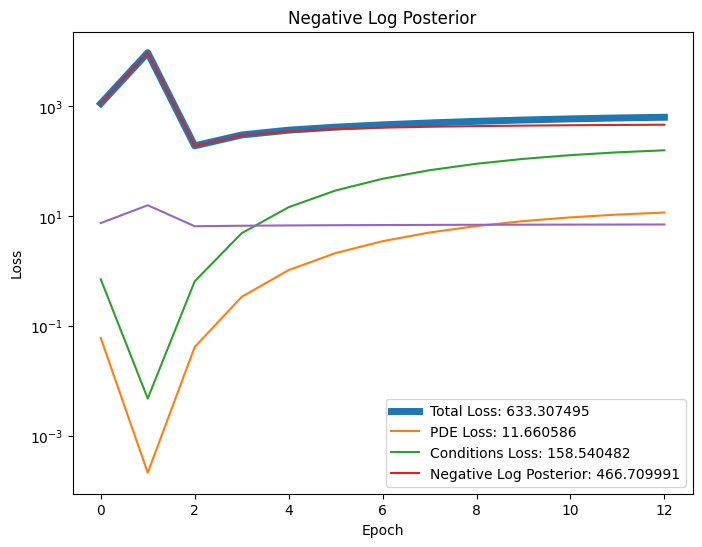

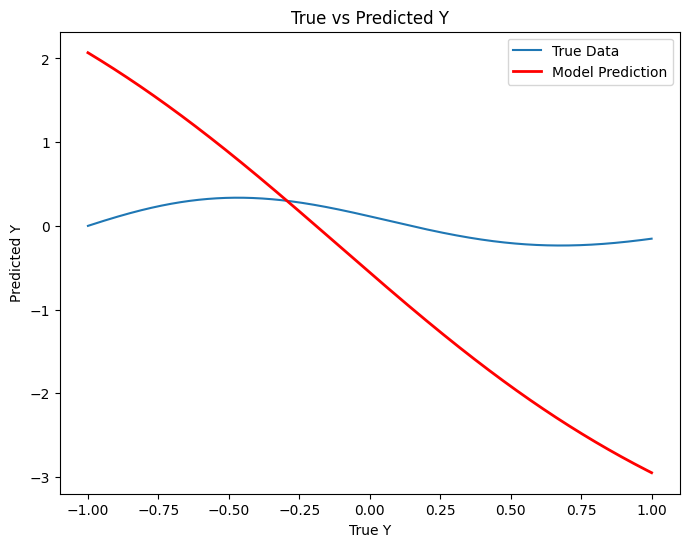

Lambda:  tf.Tensor(2.7209375, shape=(), dtype=float32)
Output size:  (1000, 1)


In [12]:
# Print RMSE
model.weights = MAP_weights
model.biases = MAP_biases
U_pred = model.forward(X_tf)
rmse = tf.sqrt(tf.reduce_mean(tf.square(Y_tf - U_pred)))
print("Best epoch at: ", best_epoch)
print(f"RMSE: {rmse.numpy():.8f}")

# Convert loss to anti-log
print(f"Loss: {(loss.numpy()):.8f}")
print(f"Anti Log Posterior = {np.exp(loss.numpy()):.6f}")

# Corrected modified loss
print(f"Corrected Modified Loss: {modified_loss.numpy():.8f}")

# Plot the loss
plt.figure(figsize=(8, 6))
plt.plot(loss_all, linewidth=5)
plt.plot(loss_all_pde)
plt.plot(loss_all_conditions)
plt.plot(loss_all_posterior)
plt.plot(modified_loss_all)
plt.axhline(y=0, color='b', linestyle='-')
#plt.text(0, 0, 'RMSE: ' + str(rmse.numpy()), fontsize=12, color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Negative Log Posterior")
# Print the loss values beside the legend names
plt.legend([f'Total Loss: {loss.numpy():.6f}', f'PDE Loss: {loss_pde.numpy():.6f}', f'Conditions Loss: {loss_conditions.numpy():.6f}', f'Negative Log Posterior: {loss_posterior.numpy():.6f}'])
'''plt.legend(["Total Loss", "PDE Loss", "Conditions Loss", "Negative Log Posterior", "Modified Loss"])
# Print all the losses
plt.text(0, 0.5, 'Total Loss: ' + str(loss.numpy()), fontsize=12, color='red') 
plt.text(0, 0.4, 'PDE Loss: ' + str(loss_pde.numpy()), fontsize=12, color='red')
plt.text(0, 0.3, 'Conditions Loss: ' + str(loss_conditions.numpy()), fontsize=12, color='red')
plt.text(0, 0.2, 'Negative Log Posterior: ' + str(loss_posterior.numpy()), fontsize=12, color='red')'''
plt.yscale('log')
# save the plot
#plt.savefig("loss_plot.png")
plt.show()


# Plot true vs predicted
plt.figure(figsize=(8, 6))
plt.plot(x, Y_tf, alpha=1, label='True Data')
plt.plot(x, U_pred, color='red', label='Model Prediction', linewidth=2)
plt.xlabel("True Y")
plt.ylabel("Predicted Y")
plt.title("True vs Predicted Y")
plt.legend()
plt.show()

print("Lambda: ", lambda_const)

# Print output size
print("Output size: ", U_pred.shape)

In [ ]:
# Print X_tf and Y_tf shape
print("X_tf shape: ", X_tf.shape)
print("Y_tf shape: ", Y_tf.shape)

# Sampling;

# Initialise MAP from model parameters
model.weights = MAP_weights
model.biases = MAP_biases
MAP = model.weights + model.biases
samples = []; new_sample = []; momentum_norm_total = []; alphas = []; proposed_H_store = []; grad_list_total = []; negative_log_posterior_list_total = []; acceptance_list = []
propose_H = 0

# Hyperparameters for HMC
num_samples = 100
step_size = 0.001 # try smaller stepsizes, cfl condition whether the step size is too large
num_leapfrog_steps = 1000

# Get gradients of the log posterior with respect to the model parameters
def grad_log_posterior(model, X, Y):
    with tf.GradientTape() as tape:
        Y_pred = model.forward(X)
        loss = negative_log_posterior(model, Y, Y_pred)
    return tape.gradient(loss, model.weights + model.biases)

# Hamiltonian Monte Carlo sampling
def hmc_sampling(model, X, Y, num_samples, step_size, num_leapfrog_steps):
    samples = [] # List to store samples
    current_sample = MAP # Start from the MAP estimate
    #current_log_prob = negative_log_posterior(model, Y, model.forward(X)).numpy()

    num_accepted = 0
    num_rejected = 0

    with tf.device('/GPU:0'):
        for k in range(num_samples):
            # Sample momentum from a Gaussian distribution
            momentum = [tf.random.normal(w.shape) for w in current_sample]
            '''# Plot momentum distribution
            print("Momentum size:" , momentum[1].numpy().ravel().shape)
            plt.figure(figsize=(10, 5))
            plt.hist(momentum[1].numpy().ravel(), bins=50)
            plt.title('Momentum')
            plt.show()'''

            # Compute the current and proposed log probabilities
            current_H = negative_log_posterior(model, Y, model.forward(X)).numpy() + 0.5 * sum((m**2).numpy().sum() for m in momentum)
            
            momentum_norm_list = []
            grad_list = []
            negative_log_posterior_list = []

            # Leapfrog integration
            new_sample = samples[-1] if samples else current_sample
            
            for l in range(num_leapfrog_steps):
                # Make a half step for momentum at the beginning
                momentum = [m - 0.5 * step_size * g for m, g in zip(momentum, grad_log_posterior(model, X, Y))]

                # Make a full step for the position
                new_sample = [w + step_size * m for w, m in zip(new_sample, momentum)]
                new_sample = [tf.Variable(w) for w in new_sample] 
                model.weights = new_sample[:3]
                model.biases = new_sample[3:]
                # Make a full step for the momentum, except at the end of the trajectory
                if l < num_leapfrog_steps - 1:
                    momentum = [m - 0.5 * step_size * g for m, g in zip(momentum, grad_log_posterior(model, X, Y))]

                # Calculate the momentum norm for each weight and bias
                momentum_norm = [tf.norm(m).numpy() for m in momentum]
                momentum_norm_list.append(momentum_norm)
                grad_norm = [tf.norm(g).numpy() for g in grad_log_posterior(model, X, Y)]
                grad_list.append(grad_norm)
                negative_log_posterior_list.append(negative_log_posterior(model, Y, model.forward(X)).numpy())  


                #print("Step: ", l+1)
                #print("Momentum Norm: ", momentum_norm)
            '''# Plot momentum norm
            plt.figure(figsize=(10, 5))
            plt.plot(momentum_norm_list)
            plt.title('Momentum Norm')
            plt.show()'''

            # Append momentum norm for every sample
            momentum_norm_total.append(momentum_norm_list)
            grad_list_total.append(grad_list)
            negative_log_posterior_list_total.append(negative_log_posterior_list)
                                
            proposed_H = negative_log_posterior(model, Y, model.forward(X)).numpy() + 0.5 * sum((m**2).numpy().sum() for m in momentum)
            print(negative_log_posterior(model, Y, model.forward(X)).numpy())
            print(0.5 * sum((m**2).numpy().sum() for m in momentum))
            proposed_H_store.append(proposed_H)

            # Accept or reject the new sample
            p = np.random.uniform()
            alpha = min(1, np.exp(proposed_H - current_H)) # proposed_H must be less than current_H to accept the sample
            alphas.append(alpha)    
            if p >= alpha: # alpha >= p  or p <= alpha
                print("Accepted")
                num_accepted = num_accepted + 1
                current_sample = new_sample
                samples.append(current_sample)
                acceptreject = 1
            else:
                print("Rejected")
                num_rejected = num_rejected + 1
                current_sample = current_sample
                acceptreject = 0

            # Print p and alpha
            print("p: ", p, " AND alpha: ", alpha)

            # Acceptance rate
            acceptance_rate = 100 * num_accepted / (num_accepted + num_rejected)
            acceptance_list.append(acceptreject)
            print("Acceptance Rate: ", acceptance_rate)
            print("-------------------------- Sample: ", k+1, "--------------------------------")

    return samples, momentum_norm_total, alphas, proposed_H_store, current_H, grad_list_total, negative_log_posterior_list_total, acceptance_list

# Perform HMC sampling
samples, momentum_norm_total, alphas, proposed_H_store, current_H, grad_list_total, negative_log_posterior_list_total, acceptance_list = hmc_sampling(model, X_tf, Y_tf, num_samples, step_size, num_leapfrog_steps)

NameError: name 'X_tf' is not defined

In [21]:
# Save all data in a file
import pickle
with open('BPINN_leapfrog1500.pkl', 'wb') as f:
    pickle.dump(samples, f)
    pickle.dump(momentum_norm_total, f)
    pickle.dump(alphas, f)
    pickle.dump(proposed_H_store, f)
    pickle.dump(current_H, f)
    pickle.dump(grad_list_total, f)
    pickle.dump(negative_log_posterior_list_total, f)
    pickle.dump(acceptance_list, f)
    pickle.dump(MAP_weights, f)
    pickle.dump(MAP_biases, f)


In [ ]:
# Load all data from the file
import pickle
with open('BPINN_leapfrog1500.pkl', 'rb') as f:
    samplessss = pickle.load(f)
    momentum_norm_totassssl = pickle.load(f)
    alphasssss = pickle.load(f)
    proposed_H_storsssse = pickle.load(f)
    current_ssssH = pickle.load(f)
    MAP_weightsssss = pickle.load(f)
    MAP_biasesssss = pickle.load(f)

# Print sizes of all the data
print("Samples size:", len(samplessss))
print("Momentum Norm size:", len(momentum_norm_totassssl))
print("Alphas size:", len(alphasssss))
print("Proposed H size:", len(proposed_H_storsssse))
print("Current H size:", current_ssssH)
print("MAP Weights size:", len(MAP_weightsssss))
print("MAP Biases size:", len(MAP_biasesssss))




Samples size: 37
Momentum Norm size: 100
Alphas size: 100
Proposed H size: 100
Current H size: 576.3668419122696
MAP Weights size: 3
MAP Biases size: 3


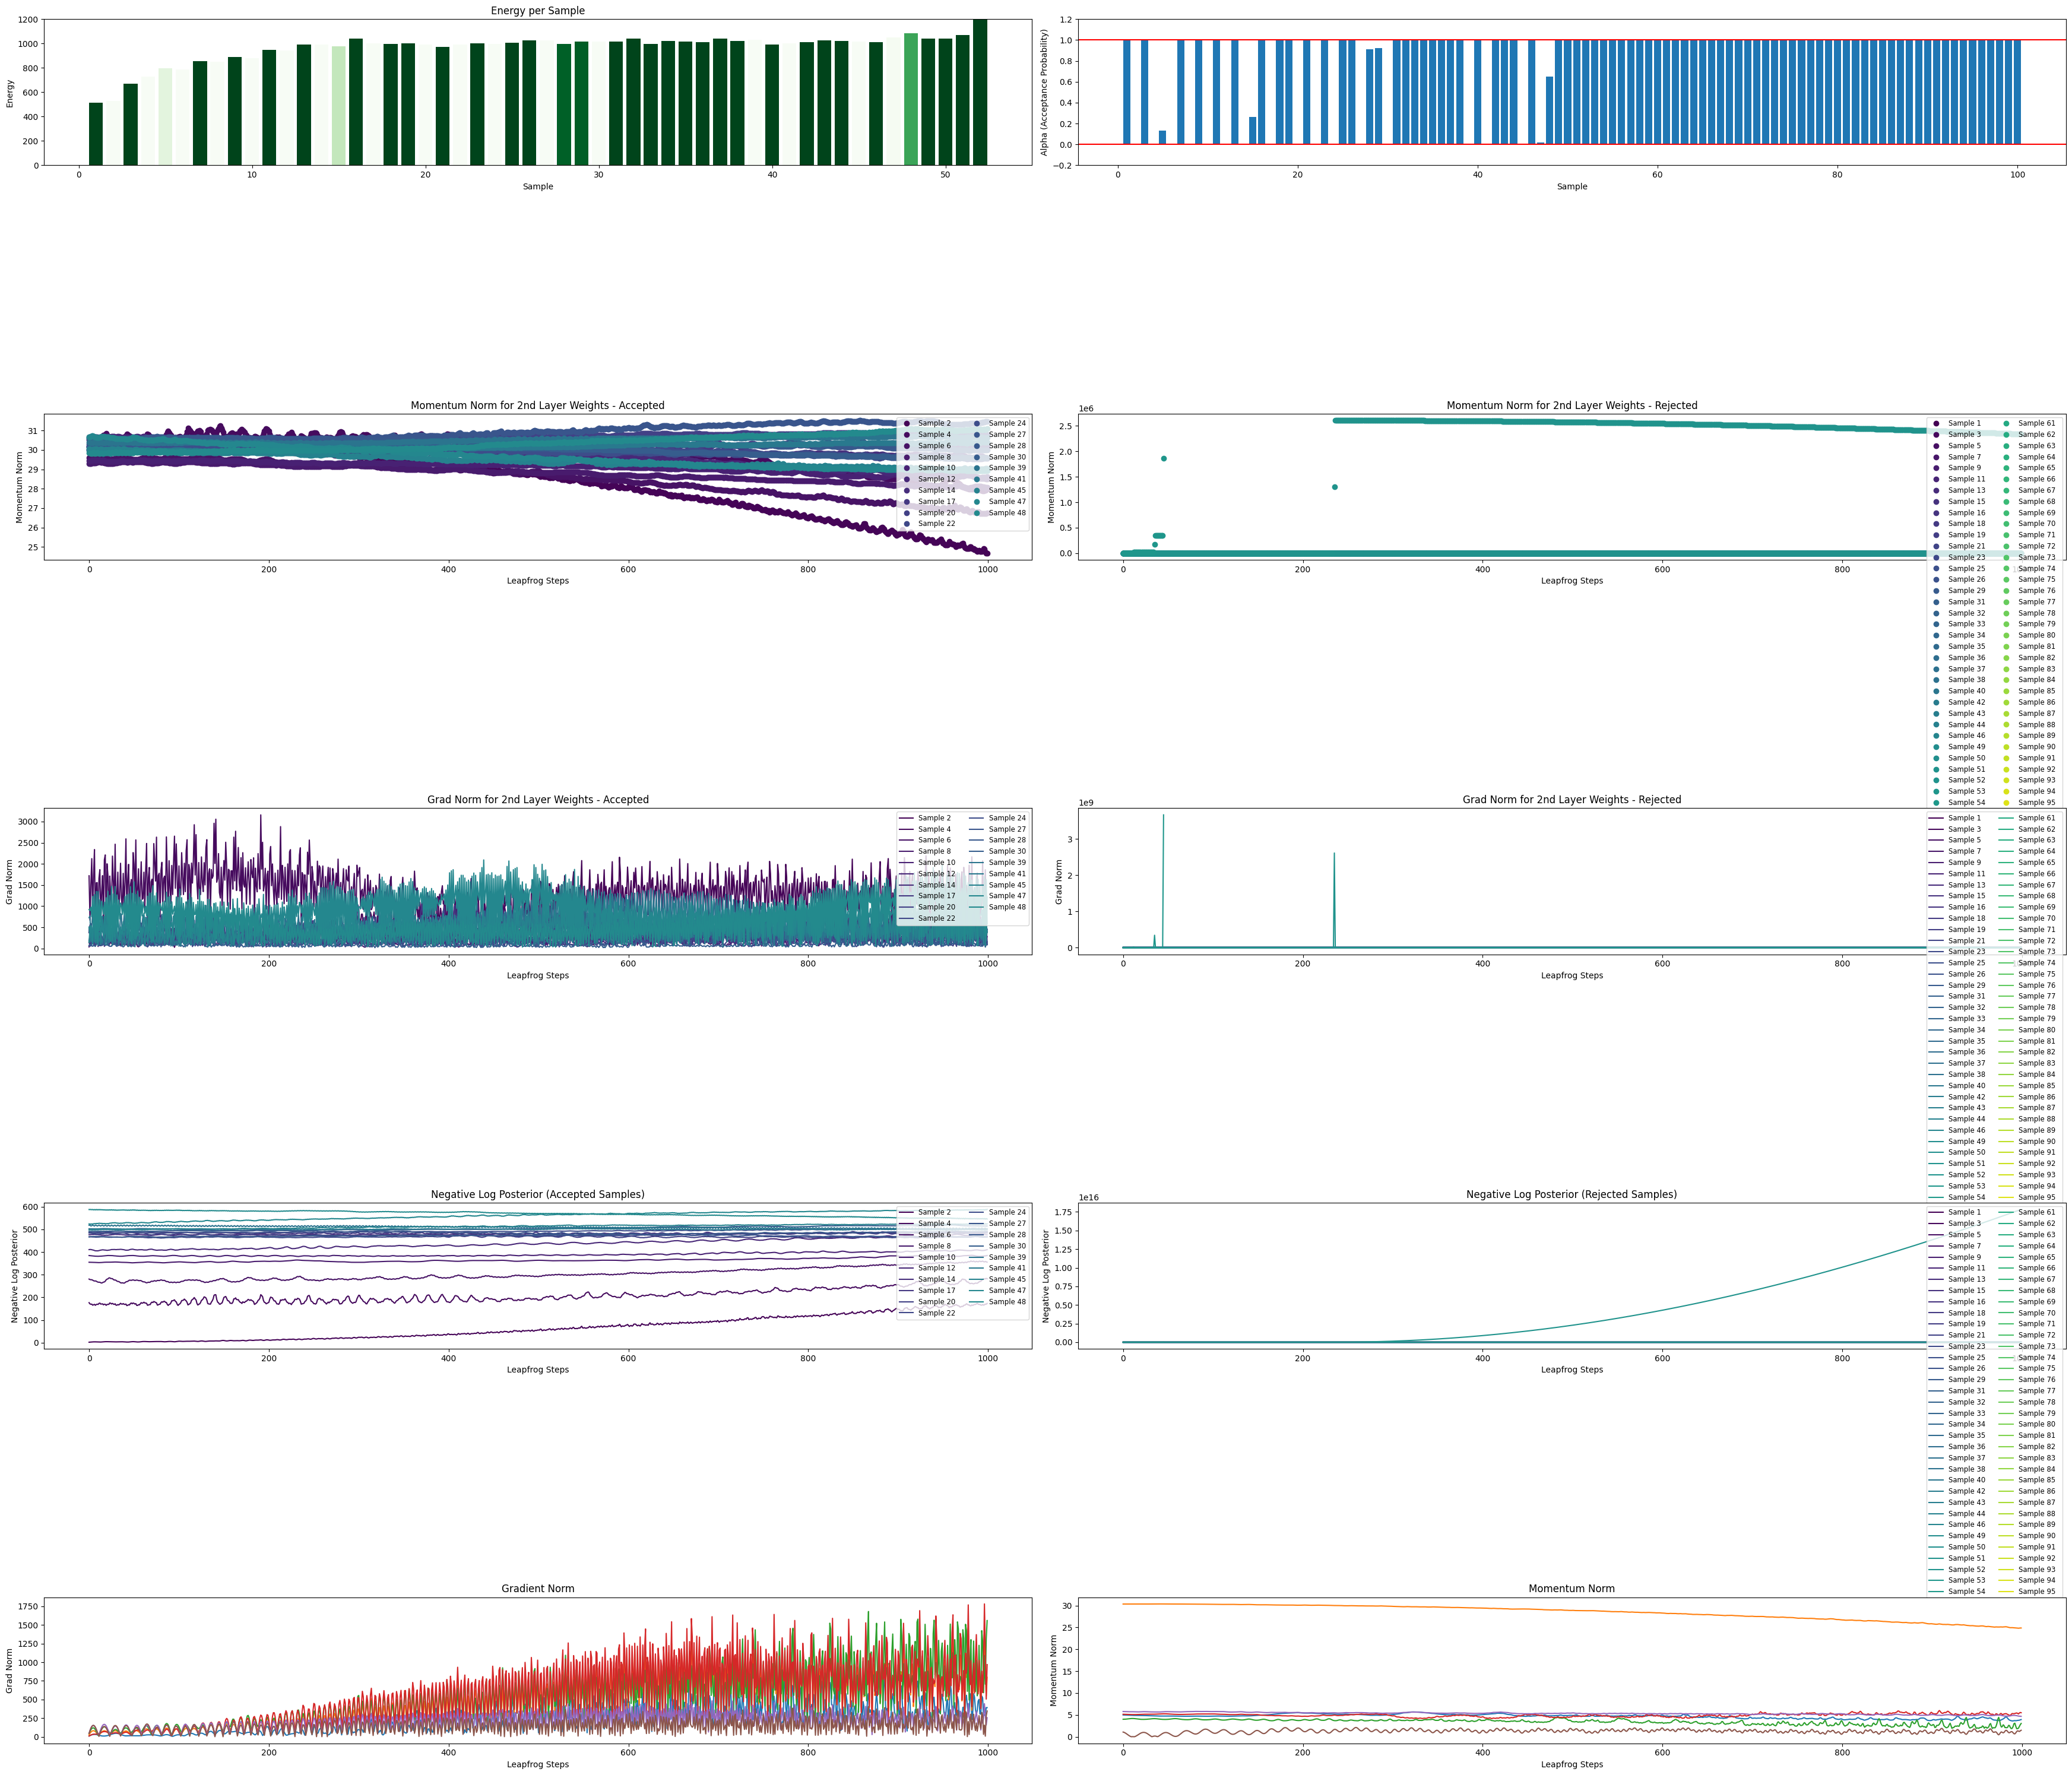

In [22]:
# Plot energy per sample
plt.figure(figsize=(35, 30))
plt.subplot(5, 2, 1)
# bar colours based on acceptance rate color map
plt.bar(range(1, num_samples+1), proposed_H_store, color=plt.cm.Greens(np.array(alphas)))
plt.axhline(y=current_H, color='r', linestyle='-')
plt.xlabel("Sample")
plt.ylabel("Energy")
plt.title("Energy per Sample")
plt.ylim(0, 1200)

plt.subplot(5, 2, 2)
# minus proposal_H_store - current_H for all
acceptance_alphas = [min(1, np.exp(proposed_H - current_H)) for proposed_H in proposed_H_store]
plt.bar(range(1, num_samples+1),alphas)
plt.ylim(-0.2,1.2)
plt.axhline(y=1, color='r', linestyle='-')
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Sample')
plt.ylabel('Alpha (Acceptance Probability)')

# Create an array of 100 colours
import matplotlib.cm as cm
colors = [cm.viridis(x) for x in np.linspace(0, 1, num_samples)]
# create array of sample 1, sample 2, sample 3, etc. for legend
samples_array = [f'Sample {i+1}' for i in range(num_samples)]
plt.subplot(5, 2, 3)
for j in range(num_samples):
    if acceptance_list[j] == 1:  # Only plot if sample was accepted
        for i in range(num_leapfrog_steps):
            if i == 0:  # Only label the first point of each accepted sample
                plt.plot(i, momentum_norm_total[j][i][1], 'o', color=colors[j], label=samples_array[j])
            else:
                plt.plot(i, momentum_norm_total[j][i][1], 'o', color=colors[j])
plt.xlabel('Leapfrog Steps')
plt.ylabel('Momentum Norm')
plt.legend(loc='upper right', ncol=2, fontsize='small')
plt.title('Momentum Norm for 2nd Layer Weights - Accepted')

plt.subplot(5, 2, 4)
for j in range(num_samples):
    if acceptance_list[j] == 0:  # Only plot if sample was accepted
        for i in range(num_leapfrog_steps):
            if i == 0:  # Only label the first point of each accepted sample
                plt.plot(i, momentum_norm_total[j][i][1], 'o', color=colors[j], label=samples_array[j])
            else:
                plt.plot(i, momentum_norm_total[j][i][1], 'o', color=colors[j])
plt.xlabel('Leapfrog Steps')
plt.ylabel('Momentum Norm')
plt.legend(loc='upper right', ncol=2, fontsize='small')
plt.title('Momentum Norm for 2nd Layer Weights - Rejected')

# Plot Grad Norm for 2nd Layer Weights (only accepted samples)
plt.subplot(5, 2, 5)
handles = []
for j in range(num_samples):
    if acceptance_list[j] == 1:  # Only plot if sample was accepted
        x_values = list(range(num_leapfrog_steps))
        y_values = [grad_list_total[j][i][1] for i in range(num_leapfrog_steps)]
        
        # Plot with lines
        line, = plt.plot(x_values, y_values, '-', color=colors[j])
        handles.append(line)
# Create the legend for accepted samples only
accepted_labels = [samples_array[j] for j in range(num_samples) if acceptance_list[j] == 1]
plt.legend(handles, accepted_labels, loc='upper right', ncol=2, fontsize='small')
plt.xlabel('Leapfrog Steps')
plt.ylabel('Grad Norm')
plt.title('Grad Norm for 2nd Layer Weights - Accepted')

# Plot Grad Norm for 2nd Layer Weights (only accepted samples)
plt.subplot(5, 2, 6)
handles = []
for j in range(num_samples):
    if acceptance_list[j] == 0:  # Only plot if sample was accepted
        x_values = list(range(num_leapfrog_steps))
        y_values = [grad_list_total[j][i][1] for i in range(num_leapfrog_steps)]
        
        # Plot with lines
        line, = plt.plot(x_values, y_values, '-', color=colors[j])
        handles.append(line)
accepted_labels = [samples_array[j] for j in range(num_samples) if acceptance_list[j] == 0]
plt.legend(handles, accepted_labels, loc='upper right', ncol=2, fontsize='small')
plt.xlabel('Leapfrog Steps')
plt.ylabel('Grad Norm')
plt.title('Grad Norm for 2nd Layer Weights - Rejected')

plt.subplot(5, 2, 7)
for i in range(num_samples):
    if acceptance_list[i] == 1:  # Accepted samples
        plt.plot(negative_log_posterior_list_total[i], color=colors[i], label=f'Sample {i+1}')

plt.xlabel('Leapfrog Steps')
plt.ylabel('Negative Log Posterior')
plt.title('Negative Log Posterior (Accepted Samples)')
plt.legend(loc='upper right', ncol=2, fontsize='small')

# Plot Negative Log Posterior for Rejected Samples
plt.subplot(5, 2, 8)
for i in range(num_samples):
    if acceptance_list[i] == 0:  # Rejected samples
        plt.plot(negative_log_posterior_list_total[i], color=colors[i], label=f'Sample {i+1}')

plt.xlabel('Leapfrog Steps')
plt.ylabel('Negative Log Posterior')
plt.title('Negative Log Posterior (Rejected Samples)')
plt.legend(loc='upper right', ncol=2, fontsize='small')

plt.subplot(5, 2, 9)
plt.plot(grad_list_total[0])
plt.xlabel('Leapfrog Steps')
plt.ylabel('Grad Norm')
plt.title('Gradient Norm')

plt.subplot(5, 2, 10)
plt.plot(momentum_norm_total[0])
plt.xlabel('Leapfrog Steps')
plt.ylabel('Momentum Norm')
plt.title('Momentum Norm')

plt.tight_layout()
plt.savefig('HMC_BPNN.png')
plt.show()

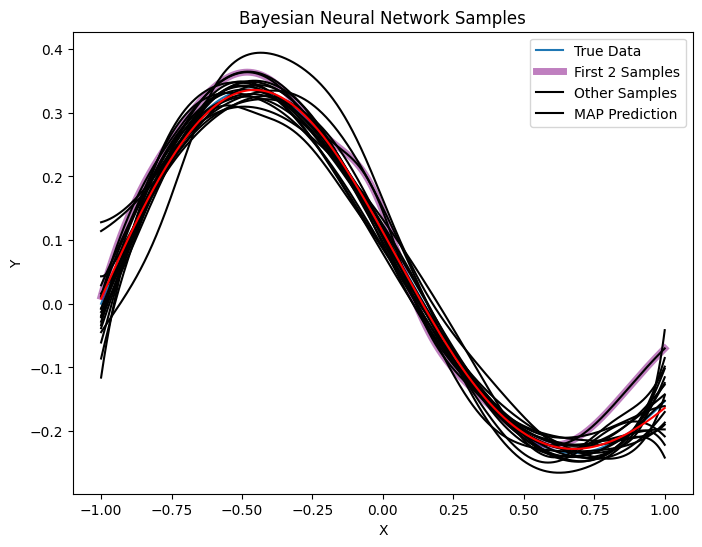

In [23]:
# Plot the samples
plt.figure(figsize=(8, 6))
plt.plot(X_tf, Y_tf, alpha=1, label='True Data')
o = 0
for sample in samples:
    model.weights = sample[:3]
    model.biases = sample[3:]
    U_pred = model.forward(X_tf)
    o = o + 1
    # Plot the model predictions
    if tf.sqrt(tf.reduce_mean(tf.square(Y_tf - U_pred))) < 100000000:
        # first samples plot purple
        if o == 0 or o == 1:
            plt.plot(x, U_pred.numpy(), color='purple', alpha=0.5, linewidth=5)
        plt.plot(x, U_pred.numpy(), color='black', alpha=1)
model.weights = MAP_weights
model.biases = MAP_biases
plt.plot(x, model.forward(X_tf).numpy(), color='red', alpha=1, label='MAP Prediction')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Bayesian Neural Network Samples")
plt.legend(['True Data', 'First 2 Samples', 'Other Samples', 'MAP Prediction'])    
plt.show()

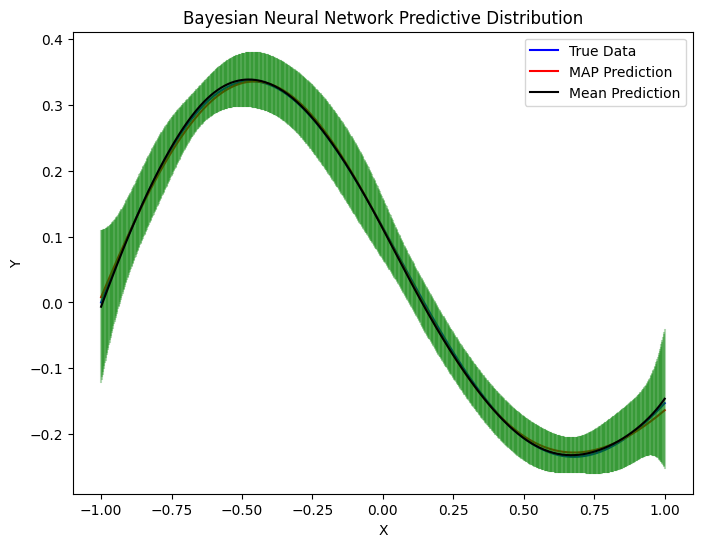

Average RMSE:  0.020529317


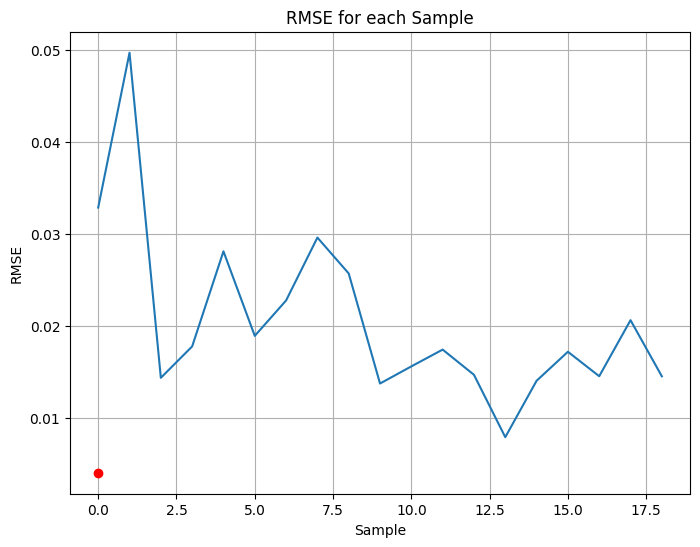

In [24]:
# Predictive distribution;
plt.figure(figsize=(8, 6))
plt.plot(X, Y, alpha=1, color='blue', label='True Data')
model.weights = MAP_weights
model.biases = MAP_biases
plt.plot(X, model.forward(X_tf).numpy(), color='red', label='MAP Prediction')
Y_preds_sampled = []
for sample in samples:
    model.weights = sample[:3]
    model.biases = sample[3:]
    Y_pred = model.forward(X_tf)
    Y_preds_sampled.append(Y_pred)
Y_preds_sampled = np.array(Y_preds_sampled)
Y_mean = np.mean(Y_preds_sampled, axis=0)
Y_std = np.std(Y_preds_sampled, axis=0)
# Plot the confidence interval
for i in range(len(X)):
    plt.plot([X[i], X[i]], [Y_mean[i] - 2 * Y_std[i], Y_mean[i] + 2 * Y_std[i]], color='green', alpha=0.3)
plt.plot(X, Y_mean, color='black', label='Mean Prediction')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Bayesian Neural Network Predictive Distribution")
plt.legend()
plt.show()

# Plot RMSE for each sample
RMSEs = []
for sample in samples:
    model.weights = sample[:3]
    model.biases = sample[3:]
    Y_preds_sampled = model.forward(X_tf)
    RMSEs.append(tf.sqrt(tf.reduce_mean(tf.square(Y - Y_preds_sampled))))
print("Average RMSE: ", np.mean(np.array(RMSEs)))
plt.figure(figsize=(8, 6))
plt.plot(rmse, marker='o', linestyle='-', color='red')
plt.plot(RMSEs)
plt.grid()
plt.xlabel("Sample")
plt.ylabel("RMSE")
plt.title("RMSE for each Sample")
plt.show()

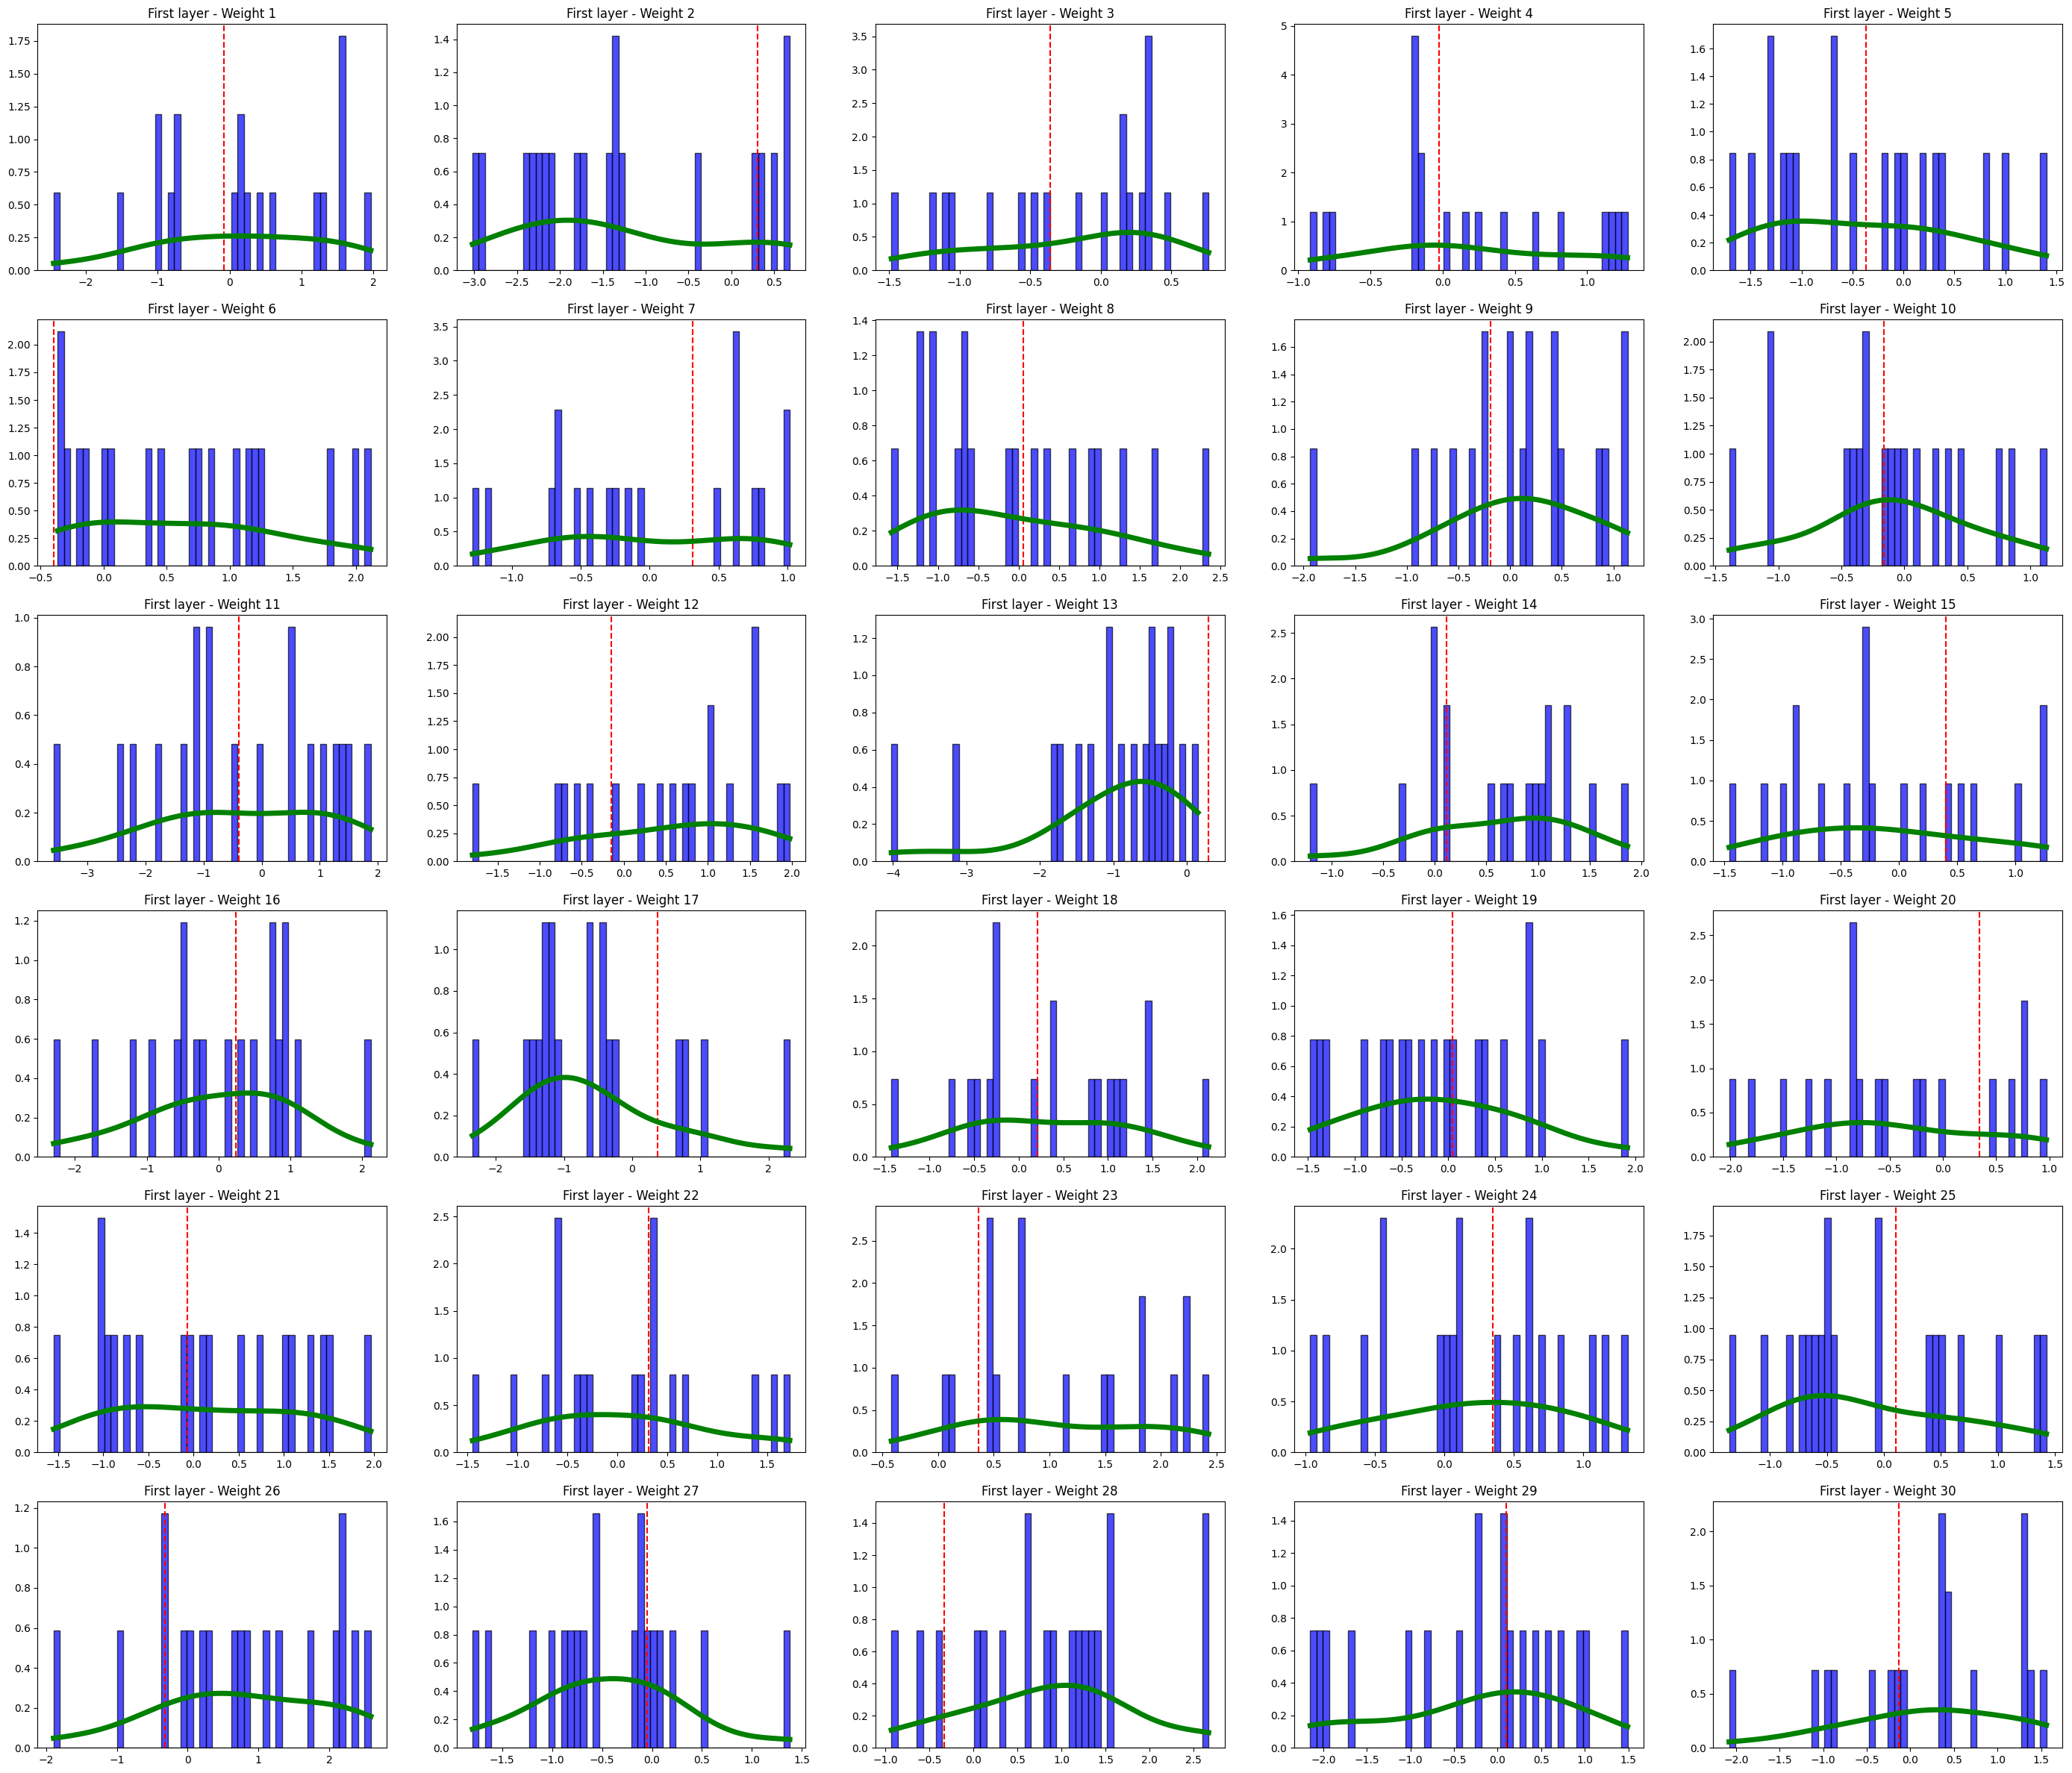

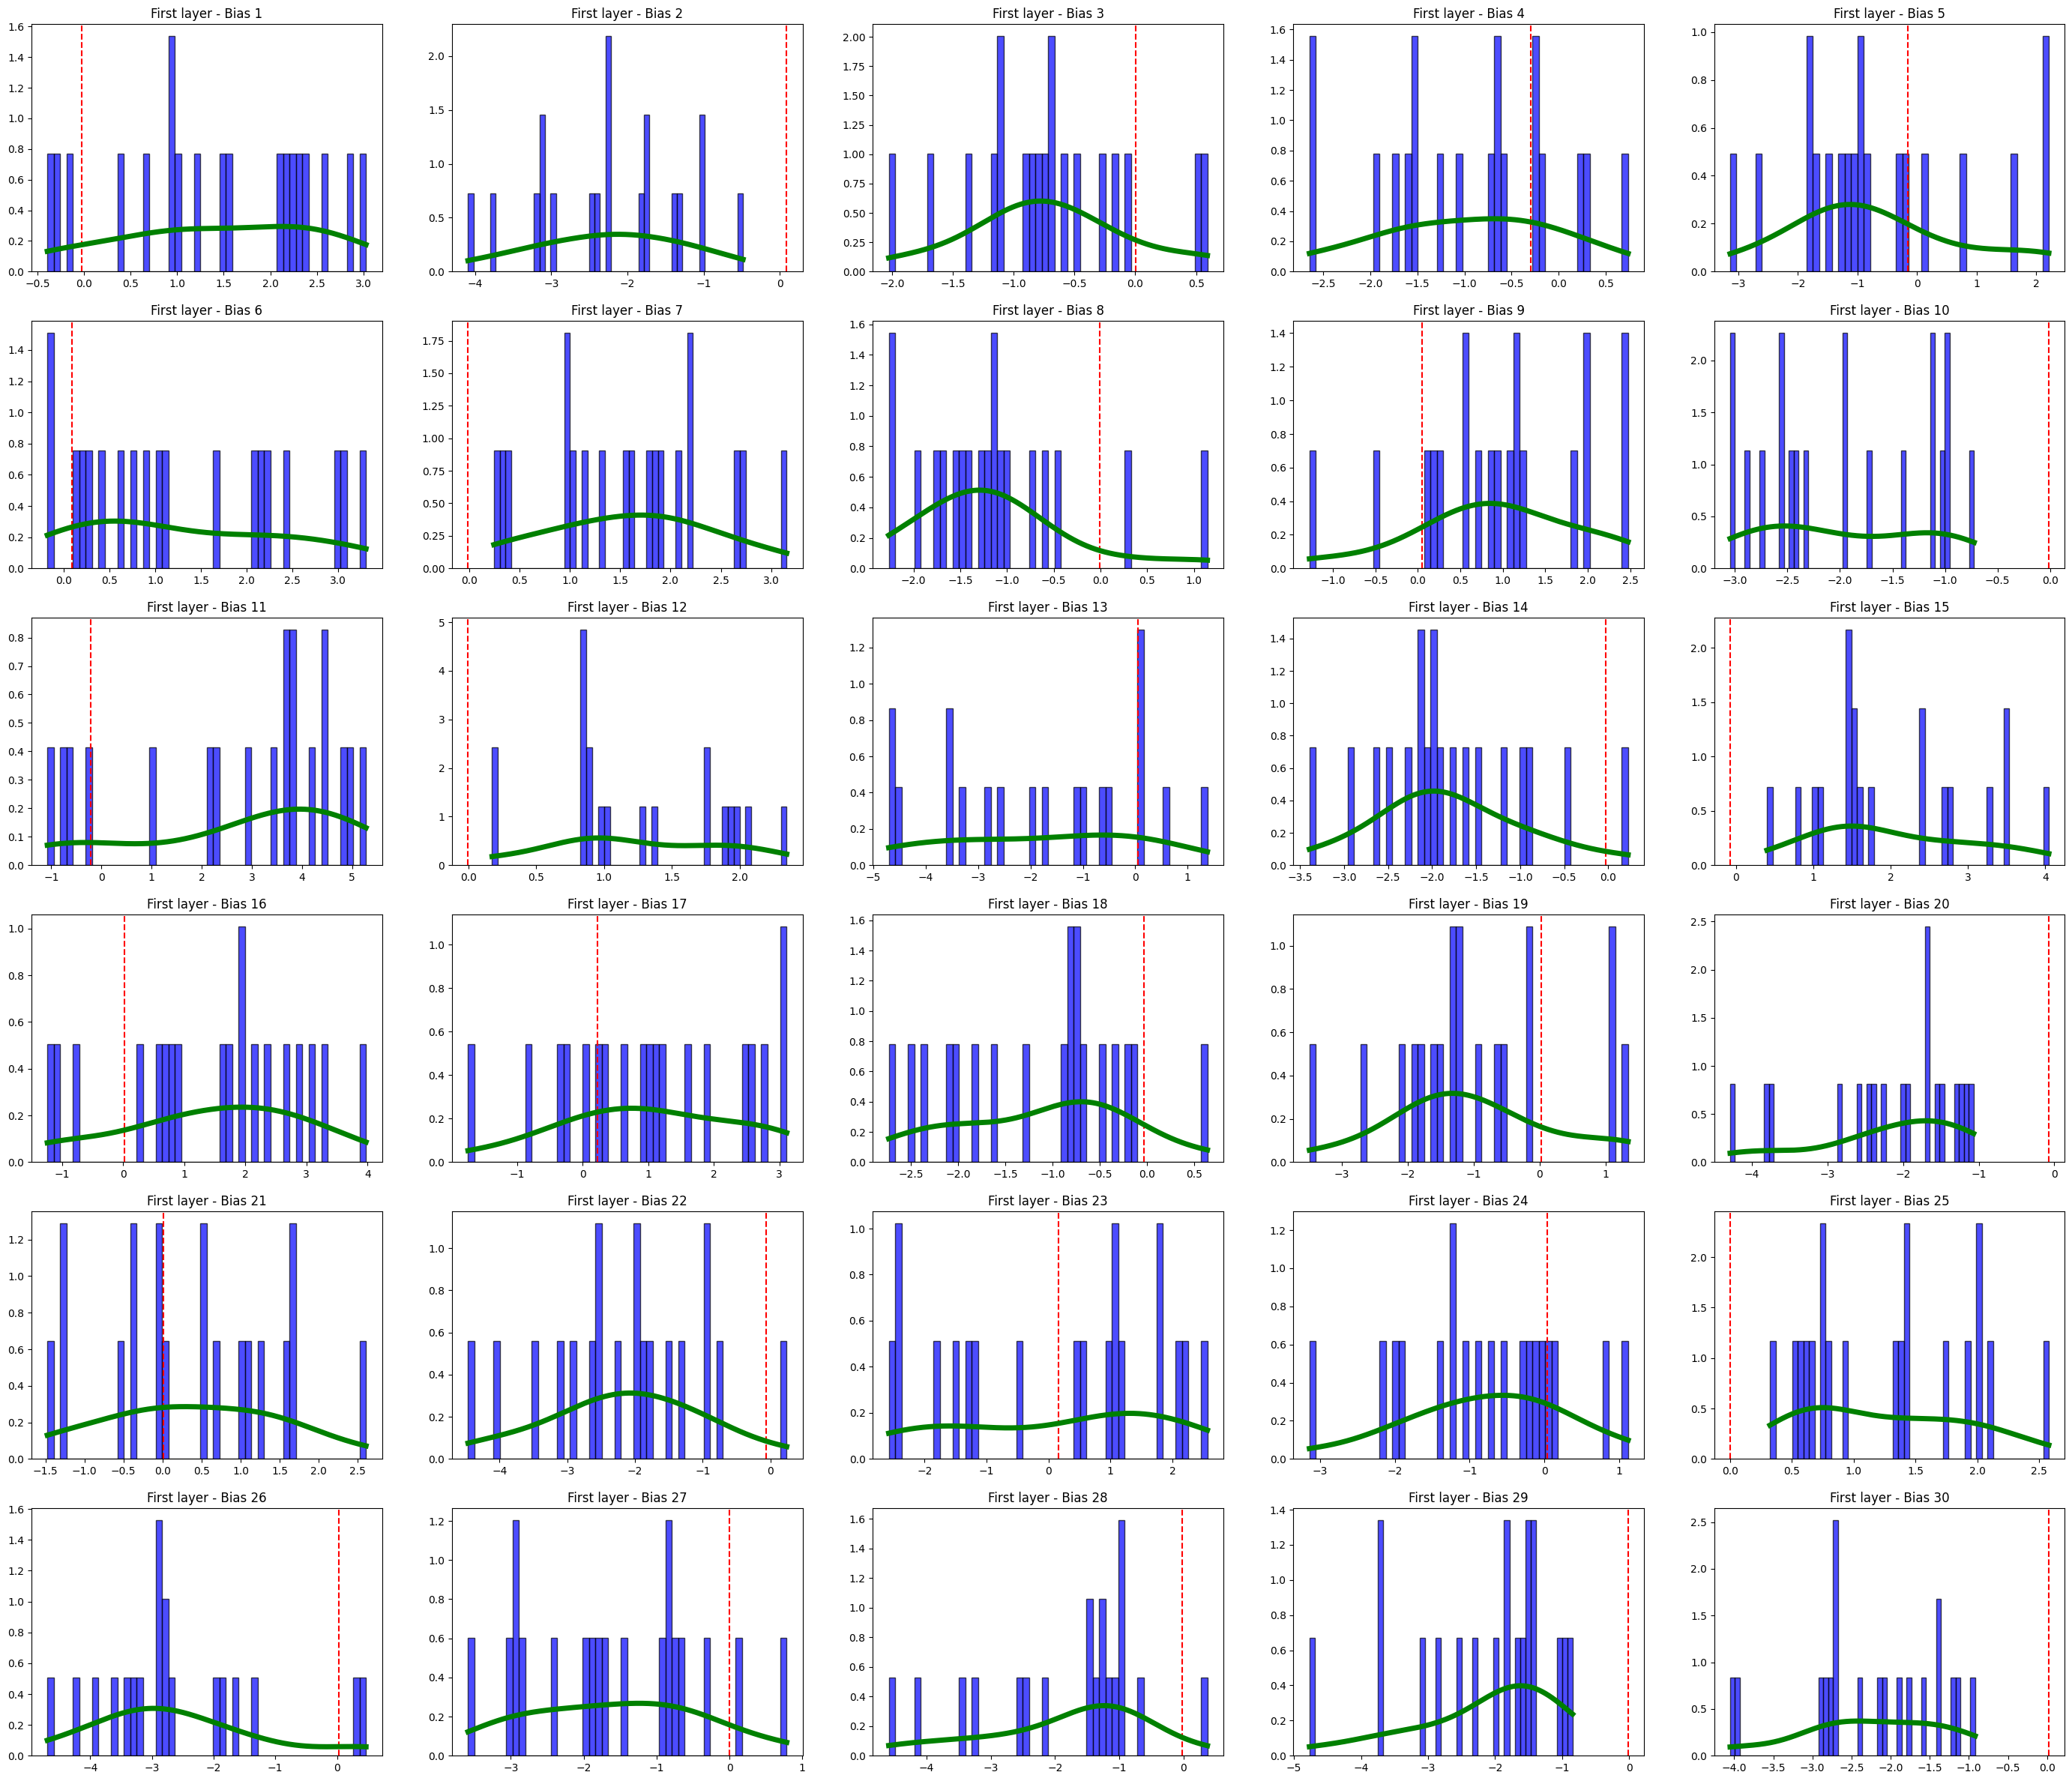

'# Do animation of plotting all samples weights using ion\nfrom IPython.display import clear_output\n\nplt.ion()\nfor i in range(0, len(samples[0][0][0])):\n    plt.figure(figsize=(8, 6))\n    clear_output(wait=True)\n    print("MAP: ", MAP_weights[0][0][i], "Sample: ", samples[0][0][0][i])\n    plot_distribution_weight(samples, MAP_weights, i, \'First layer - Weight \' + str(i+1))\n    plt.pause(0.01)\n    plt.show()'

In [25]:
# Plot distribution for first value of weights and biases in subplots
from scipy.stats import gaussian_kde

# Function to plot curve of distribution
def plot_distribution_curve(flattened_samples, title):
    kde = gaussian_kde(flattened_samples)
    x_vals = np.linspace(min(flattened_samples), max(flattened_samples), 1000)
    kde_vals = kde(x_vals)
    plt.plot(x_vals, kde_vals, color='green', label='Distribution', linewidth=5)
    plt.title(title)

# Create a function to plot the distribution of the weights and biases
def plot_distribution_weight(samples, MAP, parameter_no, layer, title):
    flattened_samples = [sample[layer][0][parameter_no].numpy() for sample in samples]
    plt.hist(flattened_samples, bins=50, alpha=0.7, color='blue', edgecolor='black', density=True)
    plt.axvline(x=MAP[layer][0][parameter_no].numpy(), color='red', linestyle='--')  
    plot_distribution_curve(flattened_samples, title) 
    plt.title(title)

def plot_distribution_bias(samples, MAP, parameter_no, layer, title):
    flattened_samples = [sample[layer+3][parameter_no].numpy() for sample in samples]
    plt.hist(flattened_samples, bins=50, alpha=0.7, color='blue', edgecolor='black', density=True)
    plt.axvline(x=MAP[layer][parameter_no].numpy(), color='red', linestyle='--')  
    plot_distribution_curve(flattened_samples, title) 
    plt.title(title)

# First layer weights
plt.figure(figsize=(35, 30))
for i in range(30):
    plt.subplot(6, 5, i+1)
    plot_distribution_weight(samples, MAP_weights, i, 0,'First layer - Weight ' + str(i+1))
plt.show()

# First layer biases
plt.figure(figsize=(35, 30))
for i in range(30):
    plt.subplot(6, 5, i+1)
    plot_distribution_bias(samples, MAP_biases, i, 0, 'First layer - Bias ' + str(i+1))
plt.show()

'''# Do animation of plotting all samples weights using ion
from IPython.display import clear_output

plt.ion()
for i in range(0, len(samples[0][0][0])):
    plt.figure(figsize=(8, 6))
    clear_output(wait=True)
    print("MAP: ", MAP_weights[0][0][i], "Sample: ", samples[0][0][0][i])
    plot_distribution_weight(samples, MAP_weights, i, 'First layer - Weight ' + str(i+1))
    plt.pause(0.01)
    plt.show()'''


In [26]:
# Print 2nd layer weight
print("Sample: ", samples[0][1].shape)
print("Sample: ", sample[1][2][29])
print("Sample: ", sample[1][2])
print("Sample: ", sample[1][29][2])
print("Sample: ", sample[1][29])

Sample:  (30, 30)
Sample:  tf.Tensor(-0.4107014, shape=(), dtype=float32)
Sample:  tf.Tensor(
[ 0.5387973  -0.2580515   0.83676434 -3.0341494   3.9792233  -2.199239
  2.9722674   1.6747609   3.0260613  -1.8809515  -0.94330883  1.6306751
  1.3075485   1.5585018  -2.1991968  -1.8233833   1.9586873   1.5862648
 -1.506859   -1.3257741   1.2317967   0.98877776 -0.01022756 -1.7236484
 -0.6149722  -0.5751043   0.51761806 -0.49850264  2.2777853  -0.4107014 ], shape=(30,), dtype=float32)
Sample:  tf.Tensor(0.6749783, shape=(), dtype=float32)
Sample:  tf.Tensor(
[ 1.4389915   4.0224857   0.6749783   1.245448   -2.3922138   1.5936004
  4.679729    0.90995276 -0.0413451  -0.8661966  -0.6729228   2.3324468
  1.0194552   2.1583729  -2.9141586  -1.0834943   1.370481    0.25282267
 -3.0970318  -3.9777117   0.5795829   1.5025269   2.177798   -3.4401445
 -0.5935941  -1.8844024   1.8718714   0.18829598  1.0931839  -3.81204   ], shape=(30,), dtype=float32)


Weights:  (19, 30, 30)
Mean weights:  (30, 30)
Std weights:  (30, 30)
MAP:  (30, 30)
Difference:  (30, 30)


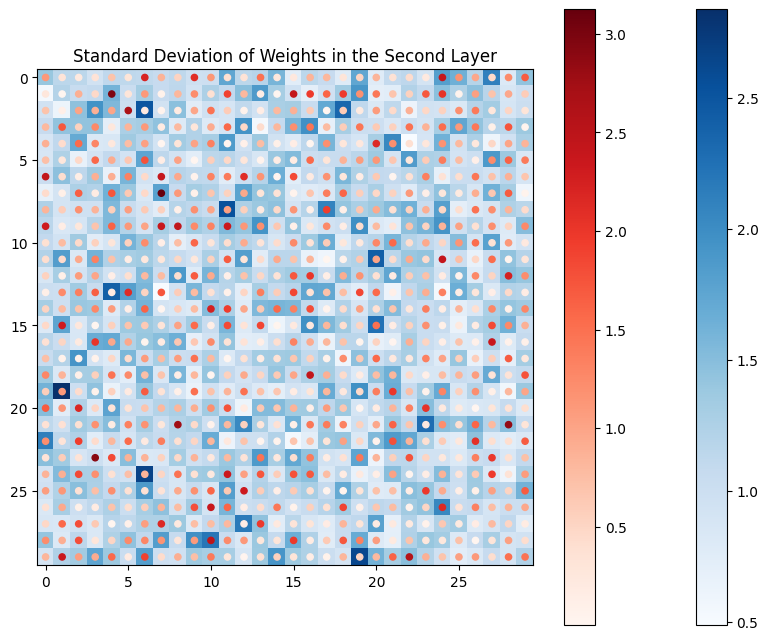

Higher the norm, the more the difference and Lower the norm, the more the similarity
Norm std weights:  36.639996
Norm diff weights:  29.626291


In [27]:
# There are 30x30 weights in the second layer with 10 samples, so we have 10x30x30 weights
# Calculate the mean and standard deviation of the weights in the second layer 
weights_2nd_layer = [sample[1] for sample in samples]
weights_2nd_layer = np.array(weights_2nd_layer) 
mean_weights_2nd_layer = np.mean(weights_2nd_layer, axis=0)
std_weights_2nd_layer = np.std(weights_2nd_layer, axis=0)

# Print the sizes
print("Weights: ", weights_2nd_layer.shape)
print("Mean weights: ", mean_weights_2nd_layer.shape)
print("Std weights: ", std_weights_2nd_layer.shape)

# Find the difference between the mean and MAP weights
diff_weights_2nd_layer = mean_weights_2nd_layer - MAP_weights[1]
diff_weights_2nd_layer = np.abs(diff_weights_2nd_layer)
print("MAP: ", MAP_weights[1].shape)
print("Difference: ", diff_weights_2nd_layer.shape)

# Plot heatmap for the std of the weights in the second layer
plt.figure(figsize=(10, 8))
plt.imshow(std_weights_2nd_layer, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.scatter(np.tile(np.arange(30), 30), np.repeat(np.arange(30), 30), c=diff_weights_2nd_layer, cmap='Reds', s=20, label='Difference from MAP')
plt.colorbar()
plt.title('Standard Deviation of Weights in the Second Layer')
plt.show()

# Create a norm for the std and difference for scoring system
norm_std_weights_2nd_layer = np.linalg.norm(std_weights_2nd_layer) 
norm_diff_weights_2nd_layer = np.linalg.norm(diff_weights_2nd_layer)
print("Higher the norm, the more the difference and Lower the norm, the more the similarity")
print("Norm std weights: ", norm_std_weights_2nd_layer)
print("Norm diff weights: ", norm_diff_weights_2nd_layer)

LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

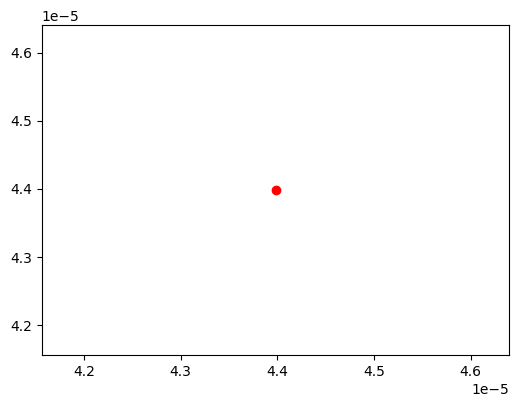

In [28]:
# Plot the distribution of the weights and biases but for 2nd layer for 3 dimensions, x-axis is weight1x1, y-axis is weight1x2, z-axis is density of the distribution
# Density can be calculated using gaussian_kde and color can be used to represent the density with a colorbar

# Create a function to 2D plot the distribution of the weights and biases and 3rd dimension is the density of the distribution with colorbar
def plot_distribution_2D(samples, MAP, parameter_no1, parameter_no2, layer, title):
    plt.plot(MAP[layer][parameter_no2][parameter_no1].numpy(), MAP[layer][parameter_no1][parameter_no2].numpy(), 'ro')
    flattened_samples = [[sample[layer][parameter_no2][parameter_no1].numpy(), sample[layer][parameter_no1][parameter_no2].numpy()] for sample in samples]
    flattened_samples = np.array(flattened_samples)
    kde = gaussian_kde(flattened_samples.T)
    x_vals = np.linspace(min(flattened_samples[:, 0]), max(flattened_samples[:, 0]), 100)
    y_vals = np.linspace(min(flattened_samples[:, 1]), max(flattened_samples[:, 1]), 100)
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = kde([X.ravel(), Y.ravel()])
    Z = Z.reshape(X.shape)
    plt.contourf(X, Y, Z, cmap='viridis')
    plt.colorbar()
    plt.title(title)

plt.figure(figsize=(35, 30))
for i in range(30):
    for j in range(1):
        plt.subplot(6, 5, i+1)
        plot_distribution_2D(samples, MAP_weights, i, j, 1, 'Second layer - Weight ' + str(i+1) + ' vs Weight ' + str(j+1))    
plt.show()

'''# Second layer weights
plt.figure(figsize=(8, 6))
plot_distribution_2D(samples, MAP_weights, p2, p1, 1, 'Second layer - Weight 1')
plt.show()

# Plot 1D for same weights at
plt.figure(figsize=(8, 6))
plt.hist([sample[1][p1][p2].numpy() for sample in samples], bins=50, alpha=0.7, color='blue', edgecolor='black', density=True)
plt.axvline(x=MAP_weights[1][p1][p2].numpy(), color='red', linestyle='--')
plot_distribution_curve([sample[1][p1][p2].numpy() for sample in samples], 'Second layer - Weight 1')
plt.title('Second layer - Weight 1')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist([sample[1][p2][p1].numpy() for sample in samples], bins=50, alpha=0.7, color='blue', edgecolor='black', density=True)
plt.axvline(x=MAP_weights[1][p2][p1].numpy(), color='red', linestyle='--')
plot_distribution_curve([sample[1][p2][p1].numpy() for sample in samples], 'Second layer - Weight 2')
plt.title('Second layer - Weight 2')
plt.show()'''
